In [1]:

import os
os.chdir('..')

import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
from data_provider.data_loader import Dataset_ETT_hour
from torch.utils.data import DataLoader

dataset = Dataset_ETT_hour(
    root_path='./dataset/ETT-small/',
    data_path='ETTh1.csv',
    flag='train',
    size=[96, 48, 96],
    features='M',
    target='OT',
    timeenc=1,
    freq='h',
)

dataloader = DataLoader(
    dataset=dataset,
    batch_size=32,
    shuffle=False,
    num_workers=10,
    drop_last=True
)

In [3]:
batch_x, batch_y, batch_x_mark, batch_y_mark = next(iter(dataloader))

batch_x.shape, batch_y.shape, batch_x_mark.shape, batch_y_mark.shape

(torch.Size([32, 96, 7]),
 torch.Size([32, 144, 7]),
 torch.Size([32, 96, 4]),
 torch.Size([32, 144, 4]))

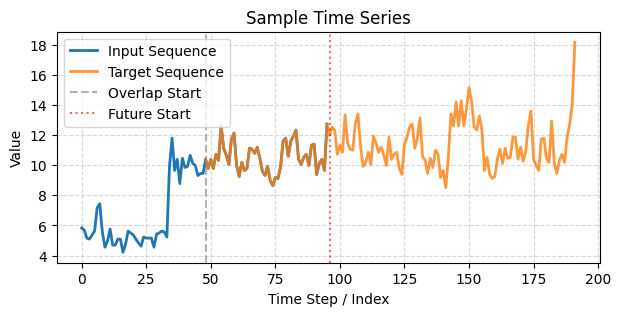

In [4]:
from utils.plotters import plot_series

plot_series(batch_x[0,:,0].numpy(), batch_y[0,:,0].numpy(), label_len=48, label_x='Input Sequence', label_y='Target Sequence', title='Sample Time Series')

In [6]:
from layers.ema import Decomp

decomp = Decomp(alpha=0.1)

season, trend = decomp(batch_x)

trend.shape, season.shape

(torch.Size([32, 96, 7]), torch.Size([32, 96, 7]))

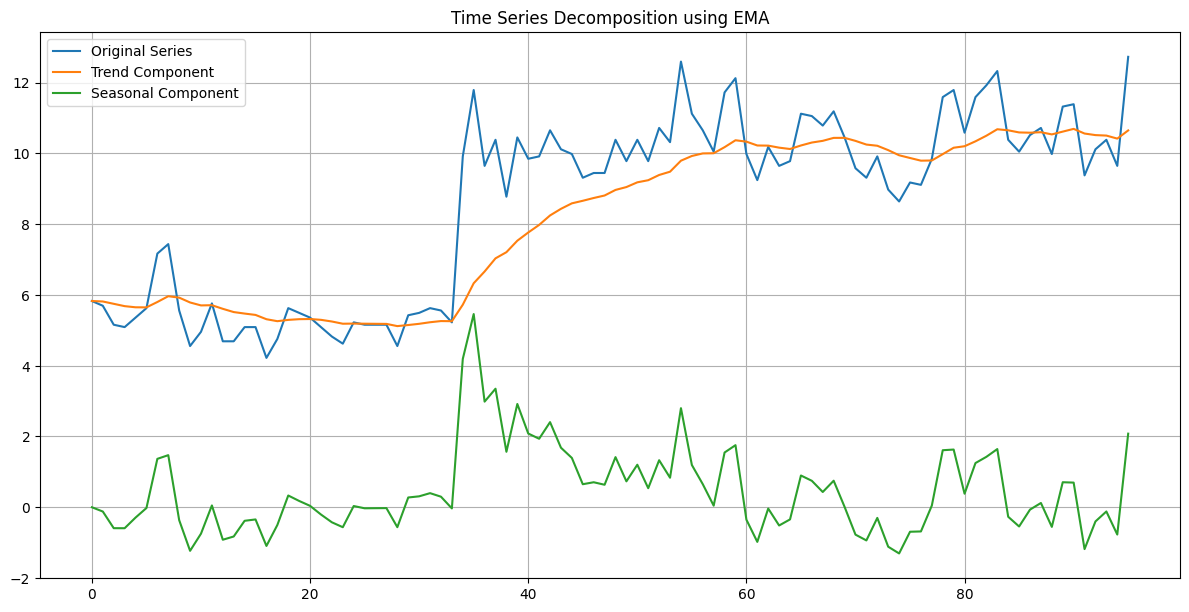

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(batch_x[0, :, 0].numpy(), label='Original Series')
plt.plot(trend[0, :, 0].numpy(), label='Trend Component')
plt.plot(season[0, :, 0].numpy(), label='Seasonal Component')
plt.legend()
plt.grid()
plt.tight_layout()
plt.title('Time Series Decomposition using EMA')
plt.show()

In [7]:
def multi_scale_resampling(x, target_lengths):
    """
    对输入时间序列进行多尺度重采样 (Downsampling/Upsampling)。
    
    Args:
        x: 输入张量。
           支持形状: 
           - [Batch, Variate, Time] (标准)
           - [Variate, Time] (单样本，会自动补Batch维度)
        target_lengths: List[int], 例如 [96, 48, 24]
        
    Returns:
        resampled_dict: {length: tensor [B, N, length]}
    """
    # ==========================================
    # 1. 维度自动修正 (Fix Dimension)
    # ==========================================
    # 如果输入是 2D [Variate, Time]，补全为 [1, Variate, Time]
    if x.dim() == 2:
        x = x.unsqueeze(0)
    
    # 双重检查：必须是 3D
    if x.dim() != 3:
        raise ValueError(f"Input tensor must be 3D [Batch, Variate, Time] or 2D [Variate, Time], but got {x.dim()}D shape {x.shape}")

    # ==========================================
    # 2. 核心插值逻辑
    # ==========================================
    resampled_dict = {}
    
    for length in target_lengths:
        # 如果长度一致，直接引用，不计算
        if length == x.shape[-1]:
            resampled_dict[length] = x
        else:
            # mode='linear' 对最后一大维 (Time) 进行插值
            x_resized = F.interpolate(x, size=length, mode='linear', align_corners=False)
            resampled_dict[length] = x_resized
            
    return resampled_dict

In [8]:
scales = [12, 24, 48, 96]
patches_dict = multi_scale_resampling(season[0, :, :].permute(1, 0), scales)

patches_dict.keys()

dict_keys([12, 24, 48, 96])

In [9]:
def plot_multiscale_subplots(resampled_dict, sample_idx=0, var_idx=0):
    """
    【分图模式】每个尺度单独画一个子图。
    用于观察实际的数据点密度。
    """
    scales = sorted(resampled_dict.keys(), reverse=True)
    n_plots = len(scales)
    
    fig, axes = plt.subplots(n_plots, 1, figsize=(10, 2.5 * n_plots), sharex=False)
    if n_plots == 1: axes = [axes]
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    
    for i, length in enumerate(scales):
        ax = axes[i]
        data = resampled_dict[length][sample_idx, var_idx, :].detach().cpu().numpy()
        
        # 这里 X 轴直接用索引 0..Length，展示真实的数据点数量
        ax.plot(data, color=colors[i % len(colors)], marker='.', linestyle='-')
        
        ax.set_title(f'Scale L={length} (Actual Points: {len(data)})')
        ax.grid(True, alpha=0.3)
        ax.set_ylabel('Val')
        
        # 可以在背景里画一个虚线的原始序列做参照
        if i > 0:
            org_len = scales[0]
            org_data = resampled_dict[org_len][sample_idx, var_idx, :].detach().cpu().numpy()
            # 需要把原始数据降采样视觉效果缩放到当前轴（仅作参考比较难对齐，这里简化只画当前数据）
            
    plt.xlabel('Index Steps (Not Physical Time)')
    plt.tight_layout()
    plt.show()

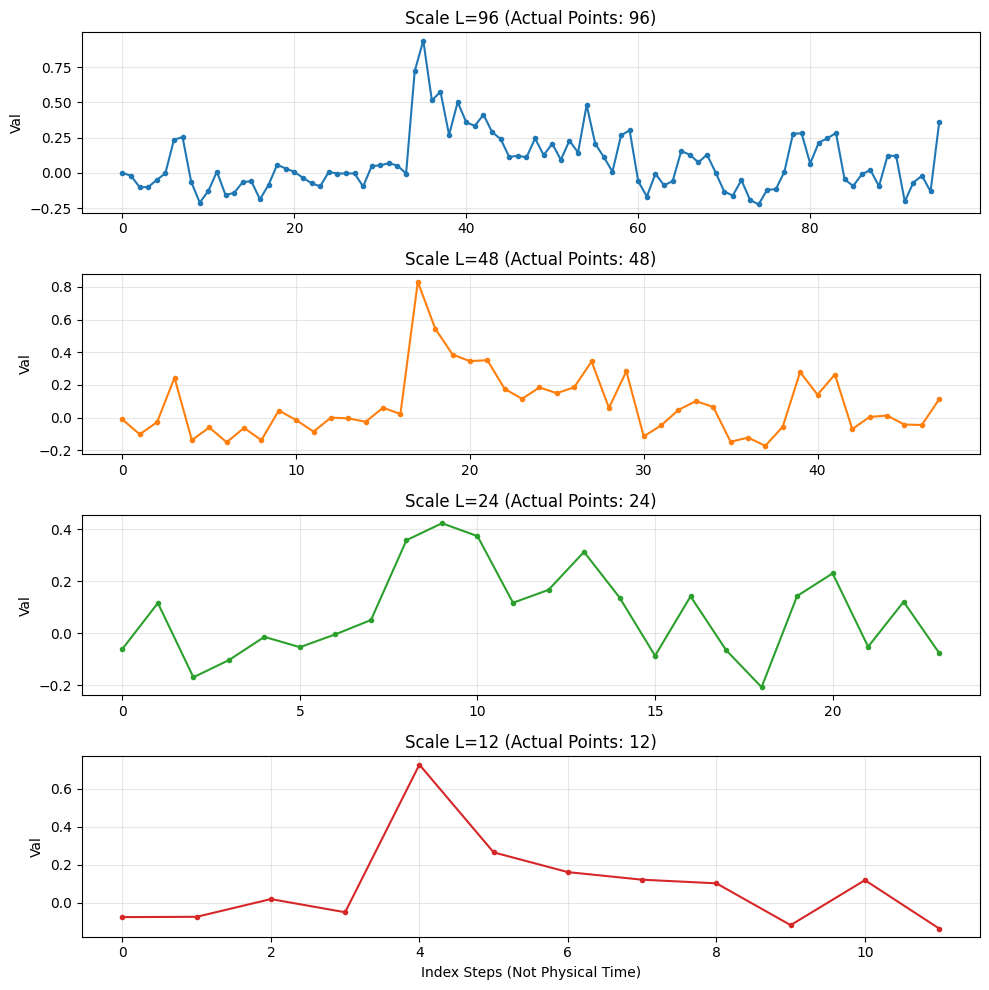

In [10]:
plot_multiscale_subplots(patches_dict, sample_idx=0, var_idx=0)

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

# ==========================================
# 1. 依赖组件 (直接复制之前的实现，确保独立可运行)
# ==========================================

def multi_scale_resampling(x, target_lengths):
    """多尺度重采样"""
    # 自动修正维度
    if x.dim() == 2: x = x.unsqueeze(0)
    
    resampled_dict = {}
    for length in target_lengths:
        if length == x.shape[-1]:
            resampled_dict[length] = x
        else:
            # 输入必须是 [B, C, T]，mode='linear' 对 T 插值
            x_resized = F.interpolate(x, size=length, mode='linear', align_corners=False)
            resampled_dict[length] = x_resized
    return resampled_dict

def resample_weight(old_weight: torch.Tensor, new_len: int):
    """Flex-Resize 权重变形"""
    assert old_weight.dim() == 2
    old_len = old_weight.size(1)
    if old_len == new_len: return old_weight
    
    old = old_weight.T 
    factor = new_len / old_len
    basis = torch.eye(old_len, dtype=torch.float32, device=old.device)
    resize_mat = F.interpolate(basis.unsqueeze(0).unsqueeze(0), 
                               size=(new_len, old_len), 
                               mode='bilinear', align_corners=False).squeeze(0).squeeze(0)
    resize_mat_pinv = torch.linalg.pinv(resize_mat.T)
    resampled = resize_mat_pinv @ old * math.sqrt(factor)
    return resampled.T

class MultiResSeasonalEmbedding(nn.Module):
    def __init__(self, d_model, target_lengths=[96, 48, 24], anchor_len=48, dropout=0.1):
        super().__init__()
        self.target_lengths = target_lengths
        self.d_model = d_model
        
        # 核心参数: Anchor Weight
        self.anchor_weight = nn.Parameter(torch.empty(d_model, anchor_len))
        self.anchor_bias = nn.Parameter(torch.zeros(d_model)) 
        nn.init.kaiming_uniform_(self.anchor_weight, a=math.sqrt(5))
        
        # 融合层
        self.fusion_layer = nn.Sequential(
            nn.Linear(len(target_lengths) * d_model, d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, d_model)
        )
        self._weight_cache = {}

    def _get_projector(self, length):
        if length in self._weight_cache: return self._weight_cache[length]
        w = resample_weight(self.anchor_weight, length)
        self._weight_cache[length] = w
        return w

    def forward(self, x):
        self._weight_cache = {}
        # 1. 重采样
        resampled_dict = multi_scale_resampling(x, self.target_lengths)
        tokens_list = []
        
        # 2. 投影
        for length in self.target_lengths:
            x_res = resampled_dict[length] # [B, N, L]
            w_L = self._get_projector(length) # [D, L]
            # F.linear(input, weight) -> input @ weight.T
            # [B, N, L] @ [D, L].T -> [B, N, L] @ [L, D] -> [B, N, D]
            out = F.linear(x_res, w_L, self.anchor_bias)
            tokens_list.append(out)
            
        # 3. 融合
        concat_tokens = torch.cat(tokens_list, dim=-1)
        final_token = self.fusion_layer(concat_tokens)
        return final_token

# ==========================================
# 2. 测试函数
# ==========================================

def test_multi_res_embedding():
    print("="*40)
    print("开始测试 MultiResSeasonalEmbedding 模块...")
    print("="*40)

    # --- 配置参数 ---
    B, N, T = 32, 7, 96  # Batch, Variate, Time
    D_model = 128
    scales = [96, 48, 24]
    anchor_len = 48
    
    # 1. 实例化模型
    model = MultiResSeasonalEmbedding(
        d_model=D_model, 
        target_lengths=scales, 
        anchor_len=anchor_len
    )
    print(f"模型初始化成功: d_model={D_model}, scales={scales}, anchor={anchor_len}")

    # 2. 构造虚拟输入 (模拟 Decomp 后的 Seasonal 成分)
    # 输入形状: [Batch, Variate, Time]
    x = torch.randn(B, N, T)
    print(f"输入数据形状: {x.shape}")

    # 3. 前向传播测试
    try:
        y = model(x)
        print(f"前向传播输出形状: {y.shape}")
        
        # 预期输出: [B, N, D_model]
        expected_shape = (B, N, D_model)
        assert y.shape == expected_shape, f"输出形状错误! 期望 {expected_shape}, 实际 {y.shape}"
        print(">> 前向传播形状检查通过 ✅")
        
    except Exception as e:
        print(f">> 前向传播失败 ❌: {e}")
        return

    # 4. 反向传播测试 (检查梯度流)
    try:
        loss = y.sum()
        loss.backward()
        
        # 检查 anchor_weight 是否有梯度
        if model.anchor_weight.grad is not None:
            grad_norm = model.anchor_weight.grad.norm().item()
            print(f"Anchor Weight 梯度 Norm: {grad_norm:.4f}")
            print(">> 反向传播梯度检查通过 ✅ (Flex-Resize 导数正常)")
        else:
            print(">> 反向传播失败 ❌: Anchor Weight 没有梯度!")
            
    except Exception as e:
        print(f">> 反向传播执行出错 ❌: {e}")

    # 5. 单样本测试 (鲁棒性检查)
    try:
        x_single = torch.randn(N, T) # 缺少 Batch 维度
        y_single = model(x_single)
        # 应该自动补全为 [1, N, D]
        if y_single.shape == (1, N, D_model):
            print(f"单样本输入测试通过 ✅: {x_single.shape} -> {y_single.shape}")
        else:
            print(f"单样本输入测试异常: {x_single.shape} -> {y_single.shape}")
    except Exception as e:
        print(f"单样本测试报错: {e}")

if __name__ == "__main__":
    test_multi_res_embedding()

开始测试 MultiResSeasonalEmbedding 模块...
模型初始化成功: d_model=128, scales=[96, 48, 24], anchor=48
输入数据形状: torch.Size([32, 7, 96])
前向传播输出形状: torch.Size([32, 7, 128])
>> 前向传播形状检查通过 ✅
Anchor Weight 梯度 Norm: 228.5560
>> 反向传播梯度检查通过 ✅ (Flex-Resize 导数正常)
单样本输入测试通过 ✅: torch.Size([7, 96]) -> torch.Size([1, 7, 128])


In [12]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x


class series_decomp(nn.Module):
    """
    Series decomposition block
    """
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean

In [ ]:
sma_decomp = series_decomp(kernel_size=25)

In [14]:
sma_season, sma_trend = sma_decomp(batch_x)

sma_season.shape, sma_trend.shape

(torch.Size([32, 96, 7]), torch.Size([32, 96, 7]))

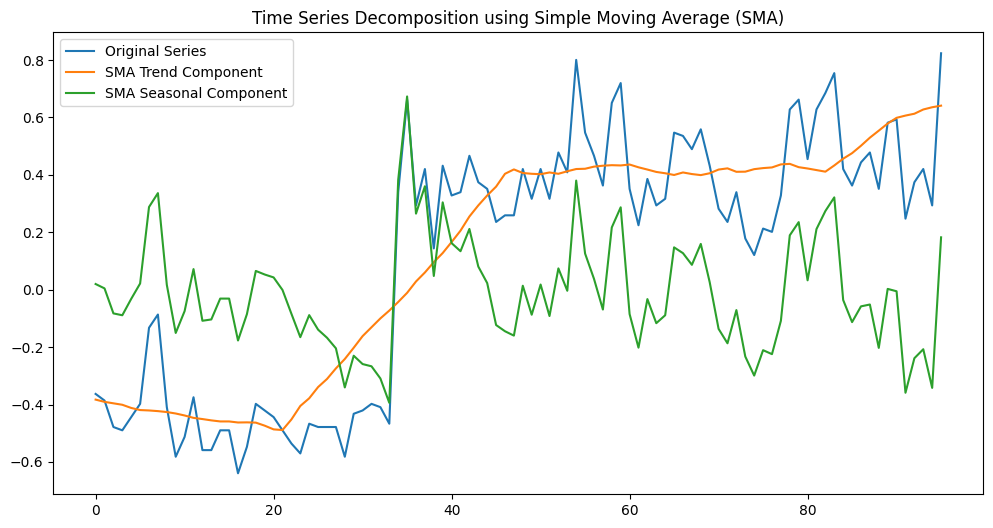

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(batch_x[0, :, 0].numpy(), label='Original Series')
plt.plot(sma_trend[0, :, 0].numpy(), label='SMA Trend Component')
plt.plot(sma_season[0, :, 0].numpy(), label='SMA Seasonal Component')
plt.legend()
plt.title('Time Series Decomposition using Simple Moving Average (SMA)')
plt.show()